# 1. Import Libraries

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Load Data

In [ ]:
df = pd.read_csv('./Walmart_Sales.csv')
print(f"Original shape: {df.shape}")
df.info()

Original shape: (6435, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


# 3. Data Preprocessing

## 3.1 Data Cleaning

### 3.1.1 Remove Duplicates

In [ ]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Duplicates removed. New shape: {df.shape}")
else:
    print("No duplicates found.")

Number of duplicate rows: 0
No duplicates found.


### 3.1.2 Handle Missing Values

In [ ]:
# Drop rows with missing Date
if df['Date'].isna().any():
    before = len(df)
    df = df[~df['Date'].isna()].reset_index(drop=True)
    print(f"Dropped {before - len(df)} rows with missing Date")

# Fill numeric columns with median
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
print("\nFilling missing values with median...")
for col in numeric_cols:
    if col in df.columns:
        missing_count = df[col].isna().sum()
        if missing_count > 0:
            df[col] = df[col].fillna(df[col].median())
            print(f"  {col}: filled {missing_count} missing values")

print("\nAfter Handling Missing Values:")
display(df.isnull().sum())


Filling missing values with median...

After Handling Missing Values:


,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


## 3.2. Data normalization

### 3.1.2 Fix Data Types

In [ ]:
# Parse Date column - handles mixed formats (DD-MM-YYYY, DD/MM/YYYY, MM/DD/YYYY)
def parse_mixed_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    date_str = str(date_str).strip()

    # Try common date formats
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y', '%Y-%m-%d', '%d-%m-%y', '%d/%m/%y']
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except:
            continue

    # Fallback to pandas inference
    try:
        return pd.to_datetime(date_str, dayfirst=True)
    except:
        return pd.NaT

# Apply date parsing
df['Date'] = df['Date'].apply(parse_mixed_date)
df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

# Convert Holiday_Flag to integer
if 'Holiday_Flag' in df.columns:
    df['Holiday_Flag'] = pd.to_numeric(df['Holiday_Flag'], errors='coerce').fillna(0).astype(int)

# Summary
nat_count = df['Date'].isna().sum()
print(f"Date parsing complete. NaT count: {nat_count}/{len(df)}")
if nat_count == 0:
    print("All dates parsed successfully")
    display(df[['Date']].head(10))
else:
    print(f"Warning: {nat_count} dates failed to parse")
    display(df[df['Date'].isna()][['Store','Date','Weekly_Sales']].head())

Date parsing complete. NaT count: 0/6435
All dates parsed successfully


,Date
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
5,2010-03-12
6,2010-03-19
7,2010-03-26
8,2010-04-02
9,2010-04-09


### 3.2.2 Validate Data

In [ ]:
print("Checking data consistency...")

print(f"\nHoliday_Flag unique values: {df['Holiday_Flag'].unique()}")

# Remove negative sales
invalid_sales = (df['Weekly_Sales'] < 0).sum()
if invalid_sales > 0:
    df = df[df['Weekly_Sales'] >= 0].reset_index(drop=True)
    print(f"Removed {invalid_sales} rows with negative Weekly_Sales")
else:
    print("No negative sales found")

# Check extreme temperatures
temp_outliers = ((df['Temperature'] < -50) | (df['Temperature'] > 150)).sum()
if temp_outliers > 0:
    print(f"Warning: {temp_outliers} rows with extreme temperatures")

print(f"\nCurrent shape: {df.shape}")

Checking data consistency...

Holiday_Flag unique values: [0 1]
No negative sales found

Current shape: (6435, 8)


# 4. Feature engineering

## 4.1 Climate Clustering by Temperature (KMeans)

Goal: group stores into climate groups (1, 2, 3, 4, 5, …) based on their typical temperature patterns.

* Calculate **Median_Temp** and **IQR_Temp** for each store from the temperature data.
* Standardize the two climate features using **StandardScaler**.
* Apply **KMeans** to cluster the stores into **K** climate groups.
* Add the **Climate_Group** label back to the original dataset by store.
* Visualize the clusters using a **Median_Temp vs. IQR_Temp** plot and show the cluster centers.


In [ ]:
K = 5

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Check if Temperature column exists
if 'Temperature' not in df.columns:
    raise ValueError('Temperature column not found in data.')

# Compute median and IQR temperature per store
store_temp = df.groupby('Store')['Temperature']
median_temp = store_temp.median()
q1 = store_temp.quantile(0.25)
q3 = store_temp.quantile(0.75)
iqr = q3 - q1

features = pd.DataFrame({
    'Store': median_temp.index,
    'Median_Temp': median_temp.values,
    'IQR_Temp': iqr.values
})

# Standardize features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features[['Median_Temp','IQR_Temp']])

# Fit KMeans
kmeans = KMeans(n_clusters=K, random_state=42)
features['Cluster'] = kmeans.fit_predict(X_scaled)

# Make cluster labels start from 1
features['Climate_Group'] = features['Cluster'] + 1

# Merge cluster label back into main dataframe
df = df.merge(features[['Store','Climate_Group']], on='Store', how='left')

# Output: number of stores per climate group
print(f"Clustering completed with K={K}.")
print("\nNumber of stores in each climate group:")
print(features.groupby('Climate_Group')['Store'].nunique())


Clustering completed with K=5.

Number of stores in each climate group:
Climate_Group
1    14
2     8
3     8
4     9
5     6
Name: Store, dtype: int64


c:\Users\minhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


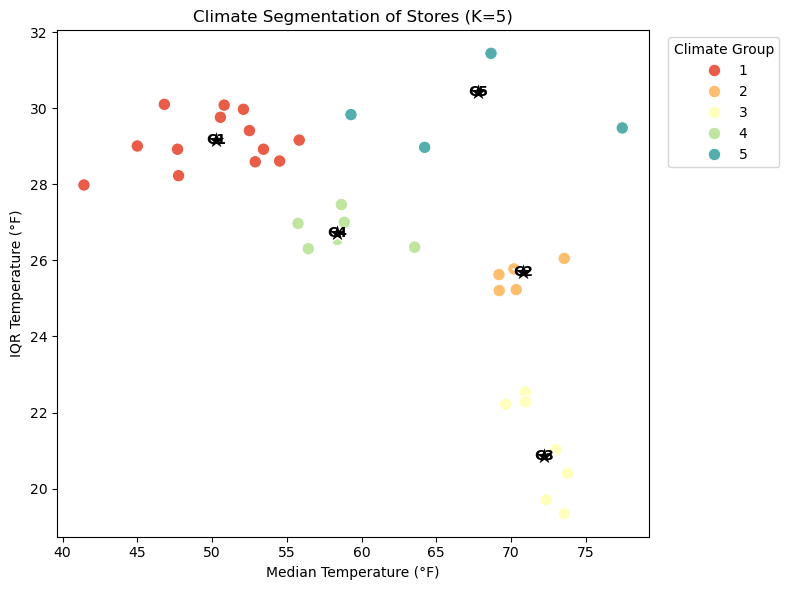

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
palette = sns.color_palette('Spectral', features['Climate_Group'].nunique())
sns.scatterplot(
    data=features,
    x='Median_Temp', y='IQR_Temp',
    hue='Climate_Group', palette=palette,
    s=80, edgecolor='white', linewidth=0.7
)

# Plot cluster centroids (converted back from scaled space)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, (mx, iq) in enumerate(centers, start=1):
    plt.scatter(mx, iq, marker='*', s=250, c='black', edgecolor='white', linewidth=1.2)
    plt.text(mx, iq, f'C{i}', fontsize=10, weight='bold', ha='center', va='center')

plt.title(f'Climate Segmentation of Stores (K={K})')
plt.xlabel('Median Temperature (°F)')
plt.ylabel('IQR Temperature (°F)')
plt.legend(title='Climate Group', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


- Nhóm 1: "Lạnh, rất biến động"
- Nhóm 2: "Ấm, ổn định"
- Nhóm 3: "Nóng, rất ổn định"
- Nhóm 4: "Mát mẻ, tương đối ổn định"
- Nhóm 5: "Nóng, biến động"



## 4.2 Save processed data

In [ ]:
# 4.2 Save processed dataframe with Climate_Group
import os
output_path = os.path.join('data','Walmart_Sales_processed_with_climate.csv')

# Kiểm tra sự tồn tại của cột Climate_Group
if 'Climate_Group' not in df.columns:
    raise ValueError("Dataframe 'df' chưa có cột Climate_Group. Hãy chạy cell phân cụm trước.")

# Đảm bảo cột Date là datetime đã xử lý (không timezone)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.tz_localize(None)

# Ghi file với định dạng ngày nhất quán YYYY-MM-DD
(df
 .sort_values(['Store','Date'])
 .to_csv(output_path, index=False, date_format='%Y-%m-%d'))

# Xác nhận và hiển thị vài dòng đầu
if os.path.isfile(output_path):
    print(f"Đã lưu file: {output_path}")
    print("Cột Date đã được lưu với định dạng YYYY-MM-DD.")
    # Đọc lại để chắc chắn (parse lại Date thành datetime)
    preview = pd.read_csv(output_path, parse_dates=['Date'])
    # Hiển thị 5 dòng đầu và kiểu dữ liệu cột Date sau khi parse
    display(preview.head())
    print(f"Kiểu dữ liệu sau khi đọc lại (Date): {preview['Date'].dtype}")
    # Nếu cần xác nhận toàn bộ dtypes
    print("\nCác kiểu dữ liệu của preview:")
    print(preview.dtypes)


Đã lưu file: data\Walmart_Sales_processed_with_climate.csv
Cột Date đã được lưu với định dạng YYYY-MM-DD.


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Climate_Group
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,3
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,3
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,3
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,3
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3


Kiểu dữ liệu sau khi đọc lại (Date): datetime64[ns]

Các kiểu dữ liệu của preview:
Store                     int64
Date             datetime64[ns]
Weekly_Sales            float64
Holiday_Flag              int64
Temperature             float64
Fuel_Price              float64
CPI                     float64
Unemployment            float64
Climate_Group             int64
dtype: object


In [52]:
import pandas as pd
df = pd.read_csv('./Walmart_Sales_processed_with_climate.csv', parse_dates=['Date'])

# 5. EDA

## 5.1 Weekly Sales of All Stores Over Time

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.express as px

fig = px.line(df, x="Date", y="Weekly_Sales", color='Store',title="Weekly Sales of All Stores Over Time")
fig.show(render='iframe')

- Sales tend to peak during specific times of the year, particularly in the final week of December when Christmas occurs, leading to a noticeable increase in revenue.

## 5.2 Avg weekly Sales of all Stores

In [ ]:
Store_avg_Sales=df.groupby(by=['Store']).agg({'Weekly_Sales':'mean'}).reset_index().rename(columns={'Weekly_Sales': 'Avg_Weekly_Sales'})
Store_avg_Sales.style.background_gradient(subset='Avg_Weekly_Sales')
fig=px.bar(Store_avg_Sales,x='Store',y='Avg_Weekly_Sales',color='Avg_Weekly_Sales',title='Avg weekly Sales of all Stores')
fig.show(render='iframe')

- The plot highlights that stores #2, #4, #13, #14, and #20 are the most profitable.
- In contrast, stores #5, #33, #36, #38, and #44 are less profitable.

## 5.3 Compare weekly sales of holiday and non-holiday

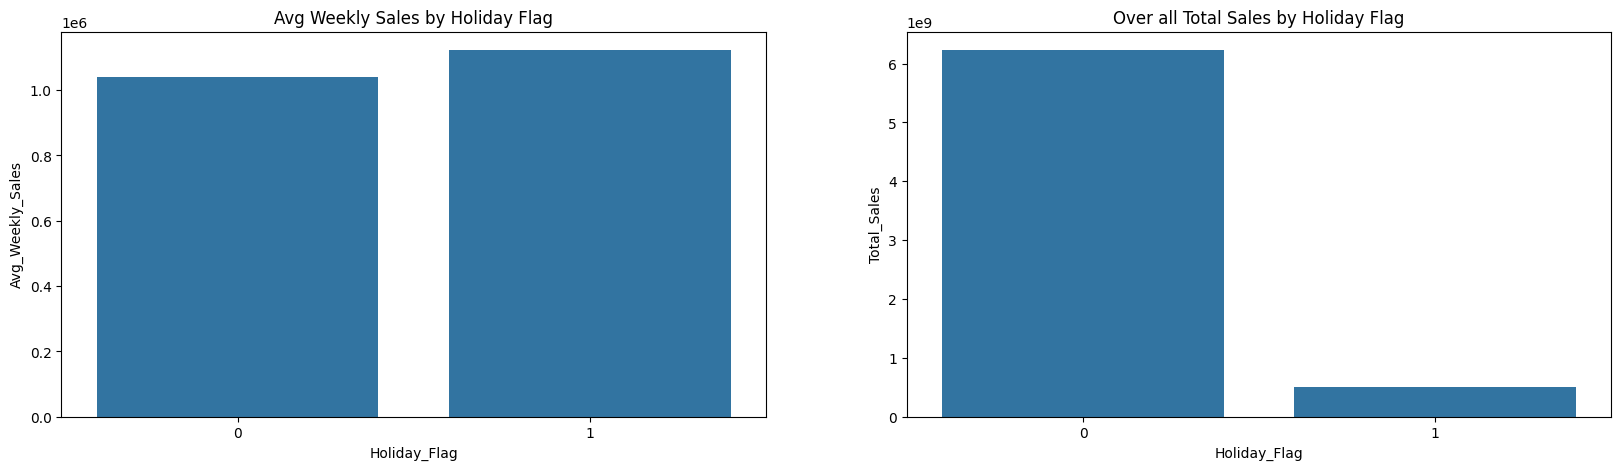

In [ ]:
# Calculate average weekly sales by Holiday_Flag
Holiday_Flag_avg_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean().reset_index().rename(columns={'Weekly_Sales': 'Avg_Weekly_Sales'})

# Calculate total weekly sales by Holiday_Flag
Holiday_Flag_total_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].sum().reset_index().rename(columns={'Weekly_Sales': 'Total_Sales'})

fix,axes=plt.subplots(1,2,figsize=(20,5))
sns.barplot(Holiday_Flag_avg_sales,x='Holiday_Flag',y='Avg_Weekly_Sales',ax=axes[0])
axes[0].set_title('Avg Weekly Sales by Holiday Flag')

sns.barplot(Holiday_Flag_total_sales,x='Holiday_Flag',y='Total_Sales',ax=axes[1])
axes[1].set_title('Over all Total Sales by Holiday Flag')

plt.show()

- The plot shows that weekly sales are higher during holiday periods. However, because holidays only occur a few times each year, the overall total sales during holidays are still lower compared to non-holiday periods.

## 5.3 Top 20 Weekly Sales by Store Over Time

In [ ]:
# Calculate the top 20 weekly sales by store over time
Top_20_Sales_df = df.nlargest(20, 'Weekly_Sales')

fig = px.scatter(Top_20_Sales_df, x="Date", y="Weekly_Sales",color='Store',size='Weekly_Sales',title='Top 20 Weekly Sales by Store Over Time')
fig.show(render='iframe')

- The plot indicates that the largest sales peak occurs on December 24, which is Christmas Eve. There are also clear increases in sales around November 25 and 26

## 5.4 Avg Monthly Sales

In [ ]:
# Calculate the average monthly sales
df['month'] = df['Date'].dt.month
Monthwise_avg_sale=df.groupby(by=['month']).agg({'Weekly_Sales':'mean'}).reset_index().rename(columns={'Weekly_Sales': 'Avg_Monthly_Sales'})

fig=px.bar(Monthwise_avg_sale,x='month',y='Avg_Monthly_Sales',color='Avg_Monthly_Sales',title='Avg. Sales by month')
fig.show(render='iframe')

- From the plots above, it is evident that the average sales per month is higher in Q4 ( especially November and December ) while January had the lowest weekly sales

## 5.5 Correlation Matrix

<Axes: >

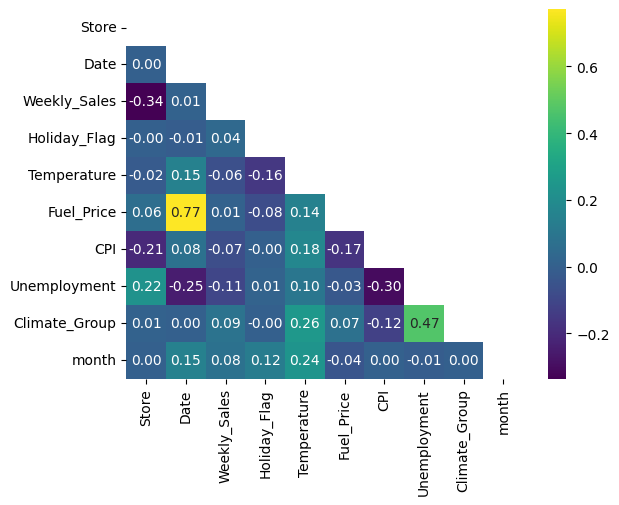

In [ ]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='viridis', annot=True, fmt='.2f')

- Fuel_Price and CPI have a strong positive correlation → when consumer prices rise, fuel prices also tend to rise.

- Date is highly correlated with Year → expected due to the progression of time.

- Weekly_Sales does not strongly correlate with any single variable → sales are likely driven by a combination of factors rather than one dominant factor.

## 5.6 FuelPrice and CPI Over Time


## 5.6.1 FuelPrice Over Time


In [ ]:
FuelPrice_Over_Time_df = df.groupby('Date')[['Fuel_Price']].agg(['mean']).reset_index()
FuelPrice_Over_Time_df.columns = ['Date', 'Avg. price']
FuelPrice_Over_Time_df['Fuel_Price'] = FuelPrice_Over_Time_df['Avg. price'] # Keep original column name for plotting

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=FuelPrice_Over_Time_df['Date'], y=FuelPrice_Over_Time_df['Fuel_Price'],
                    mode='lines+markers',
                         name='Price over time'
                    ))
fig.add_trace(go.Scatter(x=FuelPrice_Over_Time_df['Date'], y=FuelPrice_Over_Time_df['Avg. price'],
                    mode='lines',
                    name='Avg. Fuel Price'))
fig.update_layout(title='Fuel Price Over Time',
                   xaxis_title='Date',
                   yaxis_title='Price',
                 )

fig.show(render='iframe')

### 5.6.2 CPI Over Time

In [ ]:
CPI_Over_Time_df = df.groupby('Date')[['CPI']].agg(['mean']).reset_index()
CPI_Over_Time_df.columns = ['Date', 'Avg. CPI']
CPI_Over_Time_df['CPI'] = CPI_Over_Time_df['Avg. CPI'] # Keep original column name for plotting

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=CPI_Over_Time_df['Date'], y=CPI_Over_Time_df['CPI'],
                    mode='lines',
                         name='CPI over time'
                    ))
fig.add_trace(go.Scatter(x=CPI_Over_Time_df['Date'], y=CPI_Over_Time_df['Avg. CPI'],
                    mode='lines',
                    name='Avg CPI'))
fig.update_layout(title='CPI Over Time',
                   xaxis_title='Date',
                   yaxis_title='CPI',
                 )

fig.show(render='iframe')

- Fuel Price shows an upward trend and is strongly correlated with CPI.

## 5.7 Unemployment rate over time

In [ ]:
fig=px.line(df.groupby('Date').agg({'Unemployment':'mean'}).reset_index(),x='Date',y='Unemployment',title='Unemployment over the years')
fig.show(render='iframe')

- Unemployment rate shows a decreasing trend and has a weak negative correlation with Weekly Sales.

# BQ1: Does the weekly sales significantly differ among the climate groups ?


## Q1.1: Which climate group have highest avg weekly sales?


Highest average sales: Climate Group 4 (1271448.36)


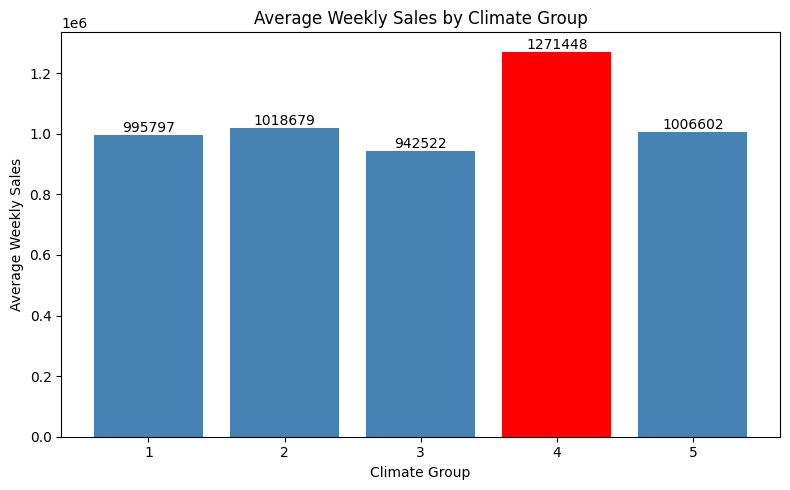

In [ ]:


# Identify group with highest average sales
highest_group = stats.loc[stats['Mean'].idxmax(), 'Climate_Group']
highest_value = stats.loc[stats['Mean'].idxmax(), 'Mean']

print(f"Highest average sales: Climate Group {highest_group} ({highest_value:.2f})")

# Plot average sales per group and highlight the highest
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(stats))
means = stats['Mean'].values
labels = stats['Climate_Group'].astype(str).values

# Highlight highest group in red, others in blue
colors = ['red' if g == highest_group else 'steelblue' for g in stats['Climate_Group']]

plt.figure(figsize=(8,5))
plt.bar(x, means, color=colors)  # bar plot
plt.xticks(x, labels)
plt.title('Average Weekly Sales by Climate Group')
plt.xlabel('Climate Group')
plt.ylabel('Average Weekly Sales')

# Add value labels above bars
for i, v in enumerate(means):
    plt.text(i, v, f"{v:.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Q1.2: Do weekly sales in each Climate Group show skewness or outliers?


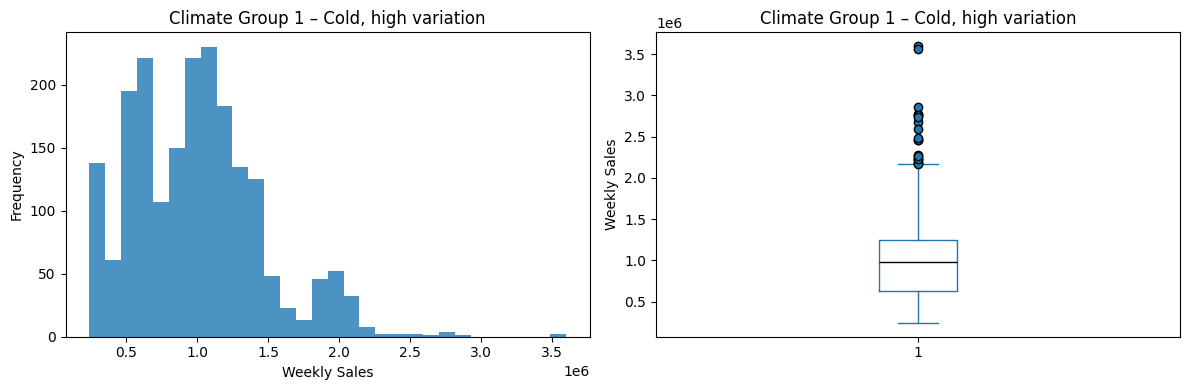

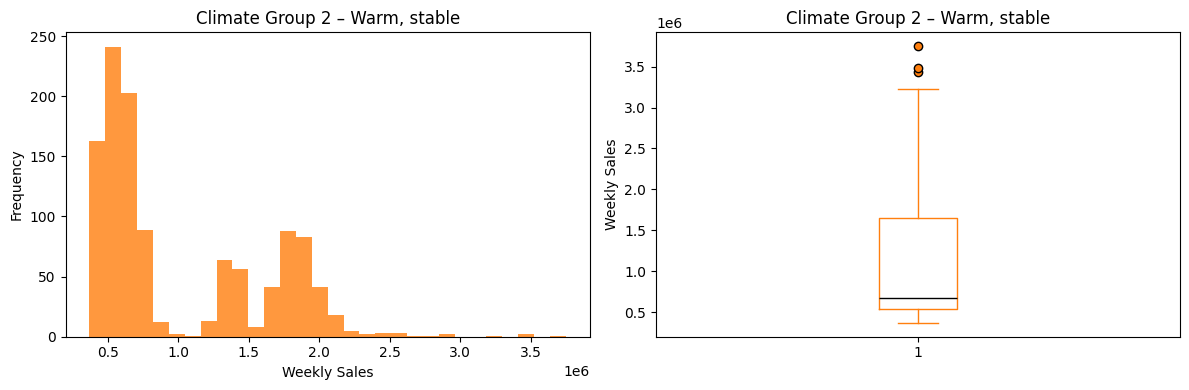

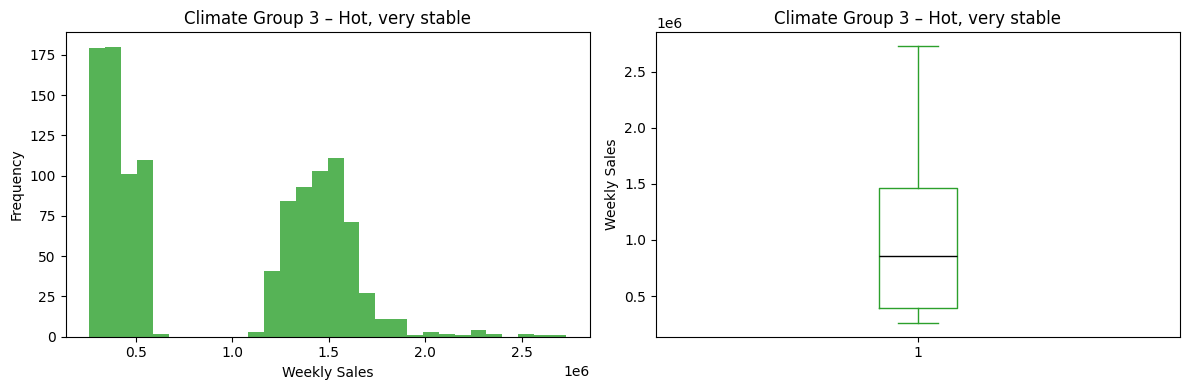

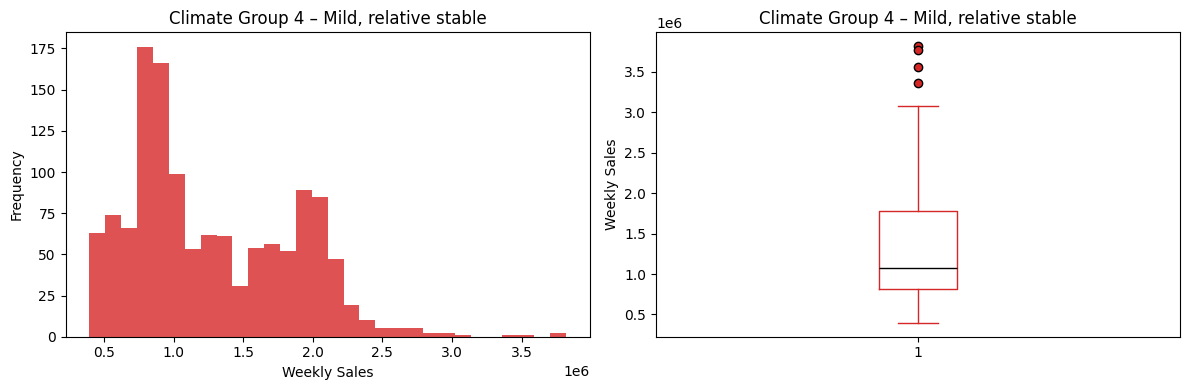

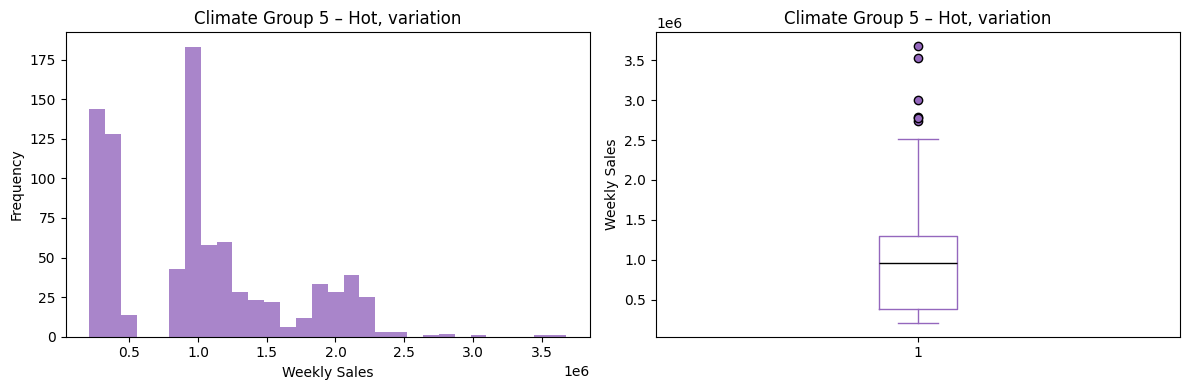

In [ ]:

# Ensure groups sorted in ascending order
groups = sorted(df['Climate_Group'].unique())
colors = plt.cm.tab10(range(len(groups)))

# English group descriptions
labels = {
    1: "Cold, high variation",
    2: "Warm, stable",
    3: "Hot, very stable",
    4: "Mild, relative stable",
    5: "Hot, variation"
}

for i, g in enumerate(groups):
    subset = df[df['Climate_Group'] == g]['Weekly_Sales']
    color = colors[i]

    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(subset, bins=30, color=color, alpha=0.8)
    plt.title(f'Climate Group {g} – {labels[g]}')
    plt.xlabel('Weekly Sales')
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(subset, vert=True,
                boxprops=dict(color=color),
                medianprops=dict(color='black'),
                whiskerprops=dict(color=color),
                capprops=dict(color=color),
                flierprops=dict(marker='o', markerfacecolor=color, markersize=6, linestyle='none')
               )
    plt.title(f'Climate Group {g} – {labels[g]}')
    plt.ylabel('Weekly Sales')

    plt.tight_layout()
    plt.show()


- Climate Group 1 (Cold, high variation): Sales change strongly.

- Climate Group 2 (Warm, stable): Sales are stable.

- Climate Group 3 (Hot, very stable): This is the most stable group.

- Climate Group 4 (Mild, relative stable): Sales change at a moderate level.

- Climate Group 5 (Hot, variation): Sales vary a lot and are hard to predict.

Insight: The more stable the climate is, the more stable the sales are.
Regions with unstable climate need stronger inventory control and seasonal marketing campaigns.

#Q1.3: Climate_Group still affects Weekly Sales when Holiday effect is removed?

In [53]:
df_non = df[df['Holiday_Flag'] == 0].copy()

groups = sorted(df_non['Climate_Group'].unique())
group_data = [df_non[df_non['Climate_Group']==g]['Weekly_Sales'] for g in groups]

df_non.groupby('Climate_Group')['Weekly_Sales'].describe()


,count,mean,std,min,25%,50%,75%,max
Climate_Group,,,,,,,,
1,1862.0,9.906377e+05,454985.927604,257361.30,622852.6800,971936.300,1.239795e+06,3595903.20
2,1064.0,1.013044e+06,597035.832900,369722.32,540622.4025,675786.330,1.641600e+06,3749057.69
3,1064.0,9.380245e+05,557243.138411,260636.71,389744.9200,853204.550,1.456840e+06,2727575.18
4,1197.0,1.264165e+06,570695.448085,395987.24,814919.1100,1074535.880,1.779237e+06,3818686.45
5,798.0,1.000262e+06,621707.969162,209986.25,381846.7975,958002.605,1.268438e+06,3676388.98


##Q1.3.1 Do Weekly Sales in each Climate Group follow a normal distribution?
- Use Normality Check (Shapiro)
- H0: Weekly Sales in this Climate Group follow a normal distribution

- H1: Weekly Sales do NOT follow a normal distribution

In [55]:
from scipy.stats import shapiro

print("=== STEP 1 — Shapiro Normality Test ===")
normality = {}

for g in groups:
    subset = df_non[df_non['Climate_Group']==g]['Weekly_Sales']
    sample = subset.sample(min(500, len(subset)), random_state=42)
    w, p = shapiro(sample)
    normality[g] = p
    print(f"Group {g}: p = {p:.6f}")

    if p < 0.05:
        print(" → Reject H0: NOT normal\n")
    else:
        print(" → Fail to reject H0: Normal\n")


=== STEP 1 — Shapiro Normality Test ===
Group 1: p = 0.000000
 → Reject H0: NOT normal

Group 2: p = 0.000000
 → Reject H0: NOT normal

Group 3: p = 0.000000
 → Reject H0: NOT normal

Group 4: p = 0.000000
 → Reject H0: NOT normal

Group 5: p = 0.000000
 → Reject H0: NOT normal



##Q1.3.2 Do Climate Groups have equal variances in Weekly Sales?
- Levene test
- H0: Variances across Climate Groups are equal
- H1: At least one Climate Group has a different variance

In [56]:
from scipy.stats import levene

print("=== STEP 2 — Levene Variance Test ===")
lev_stat, lev_p = levene(*group_data)
print(f"Levene p-value = {lev_p:.6f}")

if lev_p < 0.05:
    print(" → Reject H0: Variances are NOT equal\n")
else:
    print(" → Fail to reject H0: Variances are equal\n")

=== STEP 2 — Levene Variance Test ===
Levene p-value = 0.000000
 → Reject H0: Variances are NOT equal



###Select the Appropriate Test

In [57]:
use_anova = all(p > 0.05 for p in normality.values()) and lev_p > 0.05

if use_anova:
    print("→ ANOVA assumptions met → Use ANOVA")
else:
    print("→ ANOVA assumptions FAILED → Use Kruskal–Wallis")


→ ANOVA assumptions FAILED → Use Kruskal–Wallis


##Q1.3.3 Do Climate Groups differ in Weekly Sales after removing Holiday influence?
- Kruskal–Wallis Test
- H0: Median Weekly Sales are equal across Climate Groups
- H1: At least one Climate Group has a different median Weekly Sales

In [58]:
from scipy.stats import kruskal

print("=== STEP 3 — Kruskal–Wallis ===")
H, p_kw = kruskal(*group_data)
print(f"H = {H:.4f}, p = {p_kw:.6e}")

if p_kw < 0.05:
    print(" → Reject H0: Climate Groups are different\n")
else:
    print(" → Fail to reject H0: Climate Groups are similar\n")

=== STEP 3 — Kruskal–Wallis ===
H = 250.9411, p = 4.081448e-53
 → Reject H0: Climate Groups are different



##Q1.3.4 How strong is the Climate effect after removing holidays?

In [59]:
n = len(df_non)
k = len(groups)
eps_sq = (H - k + 1) / (n - k)

print("=== STEP 4 — Effect Size (Epsilon-squared) ===")
print(f"Epsilon-squared = {eps_sq:.4f}  (0.01 small, 0.06 medium, 0.14 large)")


=== STEP 4 — Effect Size (Epsilon-squared) ===
Epsilon-squared = 0.0413  (0.01 small, 0.06 medium, 0.14 large)


- The effect size is small (ε² ≈ 0.04), indicating that Climate_Group has a statistically detectable but practically weak impact on Weekly Sales.

###Visualize avg weekly sales without holiday-flag = 1

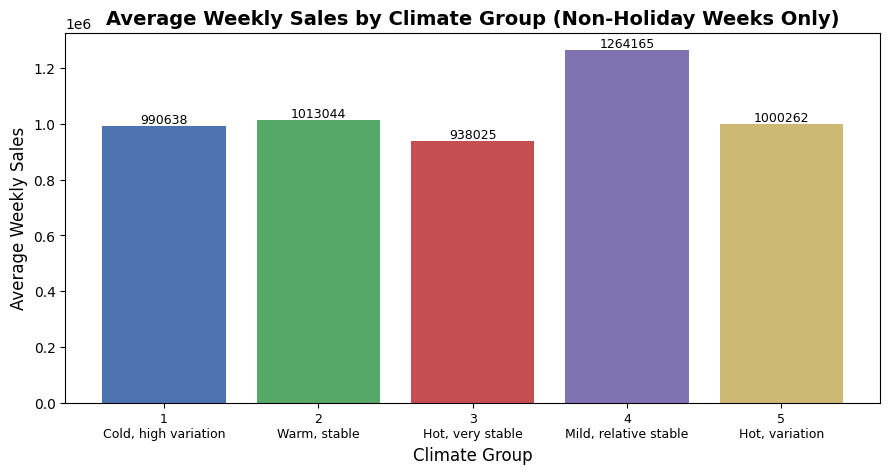

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Climate group descriptive labels
labels_climate = {
    1: "Cold, high variation",
    2: "Warm, stable",
    3: "Hot, very stable",
    4: "Mild, relative stable",
    5: "Hot, variation"
}

# Custom colors for each group
colors_climate = {
    1: '#4C72B0',  # blue
    2: '#55A868',  # green
    3: '#C44E52',  # red
    4: '#8172B2',  # purple
    5: '#CCB974'   # tan
}

# Compute mean Weekly Sales per climate group (non-holiday)
mean_stats = (
    df_non.groupby('Climate_Group')['Weekly_Sales']
    .mean()
    .reset_index()
    .sort_values('Climate_Group')
)

x = np.arange(len(mean_stats))
means = mean_stats['Weekly_Sales'].values
groups = mean_stats['Climate_Group'].values

plt.figure(figsize=(9,5))

# Apply group colors
plt.bar(x, means, color=[colors_climate[g] for g in groups])

# Replace tick labels with climate labels
plt.xticks(x, [f"{g}\n{labels_climate[g]}" for g in groups], fontsize=9)

plt.title('Average Weekly Sales by Climate Group (Non-Holiday Weeks Only)', fontsize=14, fontweight='bold')
plt.xlabel('Climate Group', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)

# Add exact values on bars
for i, v in enumerate(means):
    plt.text(i, v, f"{v:.0f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

- The ranking of average weekly sales across the 5 climate groups does not change even after removing holiday weeks. This shows that temperature is statistically meaningful and has a real impact on store sales.

# **In conclusion, Climate_group(temperature) really have statistical meaning on weekly sales not due to the influence of holiday weekly sales. However, the effect size is small (ε² ≈ 0.04), indicating that Climate_Group has a statistically detectable but practically weak impact on Weekly Sales.**

# BQ2: Is the holiday effect uniform across stores, or do some stores benefit more?

## Q2.1: Do holidays had positive effect on every store ?

,Store,NonHoliday_Sales,Holiday_Sales,Holiday_Lift
0,1,1.546957e+06,1665747.656,118790.270361
1,2,1.914209e+06,2079266.900,165058.088120
2,3,4.000648e+05,437811.050,37746.203609
3,4,2.083556e+06,2243102.624,159546.780842
4,5,3.148923e+05,359501.607,44609.330083



Number of stores where holidays DO NOT increase sales: 5
Total number of stores: 45

→ Conclusion: Holidays do NOT benefit every store.
→ Some stores receive little to no positive holiday impact.

Stores with zero or negative holiday effect:


,Store,Holiday_Lift
29,30,-1849.655782
35,36,-6312.818647
36,37,-12230.512556
37,38,-4539.202000
43,44,-7218.021782


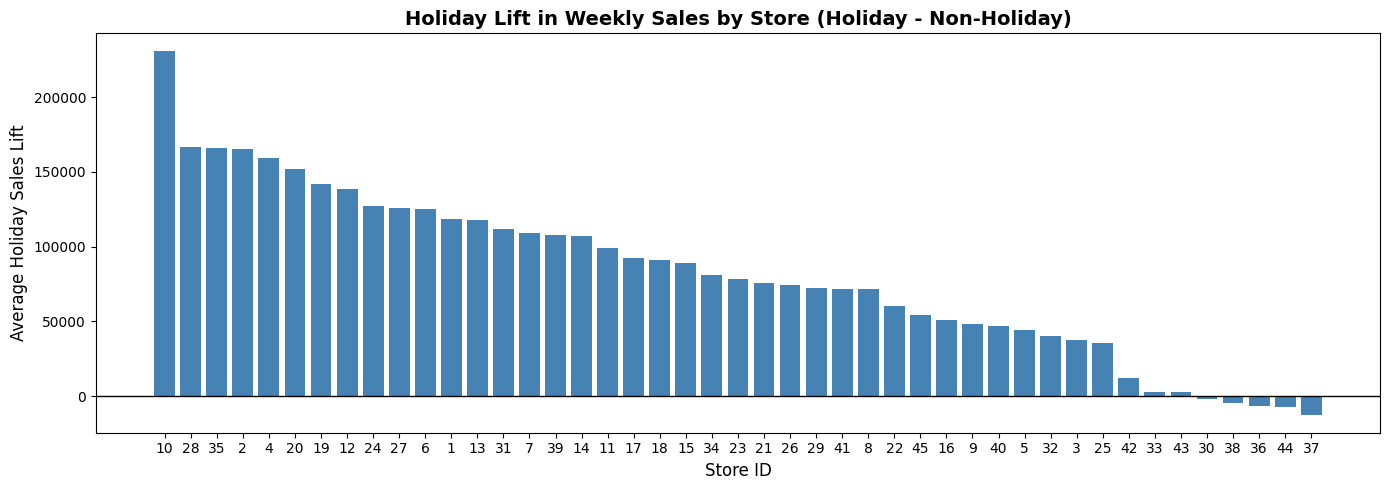

In [ ]:
# Q2.1 – Does holiday increase sales for every store?

# Compute mean sales for Holiday vs Non-Holiday
holiday_lift = (
    df.groupby(['Store', 'Holiday_Flag'])['Weekly_Sales']
      .mean()
      .unstack(fill_value=0)
      .reset_index()
)

holiday_lift.columns = ['Store', 'NonHoliday_Sales', 'Holiday_Sales']
holiday_lift['Holiday_Lift'] = holiday_lift['Holiday_Sales'] - holiday_lift['NonHoliday_Sales']

display(holiday_lift.head())

# Check how many stores do NOT benefit from holidays
stores_negative = holiday_lift[holiday_lift['Holiday_Lift'] <= 0]

print(f"\nNumber of stores where holidays DO NOT increase sales: {len(stores_negative)}")
print(f"Total number of stores: {len(holiday_lift)}")

if len(stores_negative) == 0:
    print("\n→ Conclusion: Holidays have a positive effect on ALL stores.")
else:
    print("\n→ Conclusion: Holidays do NOT benefit every store.")
    print("→ Some stores receive little to no positive holiday impact.")
    print("\nStores with zero or negative holiday effect:")
    display(stores_negative[['Store', 'Holiday_Lift']])

# Q2.1 Visualization: Holiday Lift per Store (sorted, no labels on bars)
# Q2.1 Visualization: Holiday Lift per Store (sorted high → low, x-axis shows Store ID)

import matplotlib.pyplot as plt

# Compute holiday lift
holiday_lift = (
    df.groupby(['Store', 'Holiday_Flag'])['Weekly_Sales']
      .mean()
      .unstack(fill_value=0)
      .reset_index()
)
holiday_lift.columns = ['Store', 'NonHoliday_Sales', 'Holiday_Sales']
holiday_lift['Holiday_Lift'] = holiday_lift['Holiday_Sales'] - holiday_lift['NonHoliday_Sales']

# Sort from highest to lowest
holiday_lift_sorted = holiday_lift.sort_values('Holiday_Lift', ascending=False)

# Plot column chart
plt.figure(figsize=(14, 5))
plt.bar(holiday_lift_sorted['Store'].astype(str), holiday_lift_sorted['Holiday_Lift'], color='steelblue')
plt.axhline(y=0, color='black', linewidth=1)

plt.title('Holiday Lift in Weekly Sales by Store (Holiday - Non-Holiday)', fontsize=14, fontweight='bold')
plt.xlabel('Store ID', fontsize=12)
plt.ylabel('Average Holiday Sales Lift', fontsize=12)

# Ensure store codes display clearly
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()




## Q2.2: Why do some stores have a drop in sales during the holidays?

In [49]:
# ================================
# PART 1: Compute Holiday Lift for ALL stores
# ================================
holiday_lift = (
    df.groupby(['Store', 'Holiday_Flag'])['Weekly_Sales']
      .mean()
      .unstack(fill_value=0)
      .reset_index()
)
holiday_lift.columns = ['Store', 'NonHoliday_Sales', 'Holiday_Sales']
holiday_lift['Holiday_Lift'] = holiday_lift['Holiday_Sales'] - holiday_lift['NonHoliday_Sales']

print("Holiday lift statistics:")
display(holiday_lift.head())

# Merge NonHoliday_Sales back to full df
df_all = df.merge(holiday_lift[['Store', 'NonHoliday_Sales']], on='Store', how='left')

# Compute Holiday Uplift per row
df_all['Holiday_Uplift'] = df_all['Weekly_Sales'] - df_all['NonHoliday_Sales']

# ================================
# PART 2: Prepare features and target (ALL stores)
# ================================
features = ['NonHoliday_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature']

X = df_all[features]
y = df_all['Holiday_Uplift']

# ================================
# PART 3: Train/Test Split
# ================================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================================
# PART 4: Train Model (Random Forest)
# ================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

# ================================
# PART 5: Aggregate predictions by Store
# ================================
results = X_test.copy()
results['Actual_Uplift'] = y_test
results['Predicted_Uplift'] = y_pred
results['Store'] = df_all.loc[X_test.index, 'Store']

store_summary = (
    results.groupby('Store')[['Actual_Uplift', 'Predicted_Uplift']]
    .mean()
    .reset_index()
)
store_summary['Difference'] = store_summary['Predicted_Uplift'] - store_summary['Actual_Uplift']

print("Holiday Uplift Predictions by Store:")
display(store_summary)



Holiday lift statistics:


,Store,NonHoliday_Sales,Holiday_Sales,Holiday_Lift
0,1,1.546957e+06,1665747.656,118790.270361
1,2,1.914209e+06,2079266.900,165058.088120
2,3,4.000648e+05,437811.050,37746.203609
3,4,2.083556e+06,2243102.624,159546.780842
4,5,3.148923e+05,359501.607,44609.330083


MSE: 13873115079.86
Holiday Uplift Predictions by Store:


,Store,Actual_Uplift,Predicted_Uplift,Difference
0,1,-7457.105639,1087.847973,8544.953612
1,2,14339.937238,-10923.453128,-25263.390365
2,3,-2241.896105,2063.995275,4305.891380
3,4,-25736.241283,33533.100729,59269.342012
4,5,540.077749,-3645.392645,-4185.470394
5,6,-29570.488244,-5334.314242,24236.174002
6,7,10584.079925,-6455.415538,-17039.495463
7,8,21104.644519,14015.560817,-7089.083702
8,9,3598.380524,3909.953204,311.572680
9,10,22024.769303,-29486.538282,-51511.307585


SHAP summary plot for Holiday Uplift prediction:


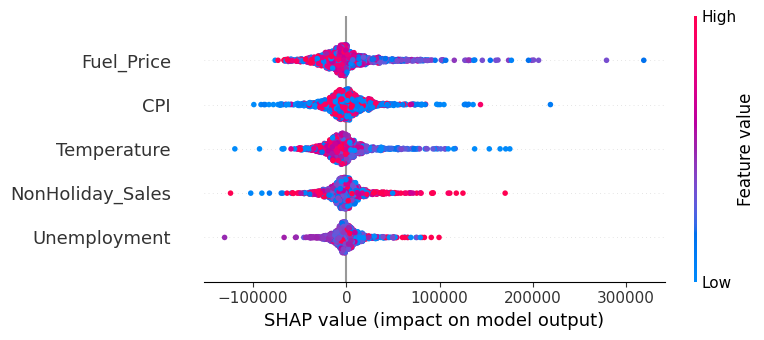

In [ ]:
# ================================
# PART 6: SHAP explanation
# ================================
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
print("SHAP summary plot for Holiday Uplift prediction:")
shap.summary_plot(shap_values, X_test)

According to the SHAP summary report, negative holiday_uplift stores were the stores that have:
- High fuel price → People travel less → shop less often.
- Warm or hot temperature → Reduced holiday shopping motivation, fewer in-store visits.
- High non-holiday sales → Stores that sell a lot on normal days cannot grow much during holidays → demand is already “full.”
- CPI and Unemployment rate are ambiguous because these are macro variables that have the same impact on all stores, so they do not create a big difference between stores => The holiday uplift issue is localized and behavioral

# **In conlusion, the holiday effect was not uniform across stores, or do some stores benefit. There were many outside factors that effect the holiday sales index such as fuel price, temperature, non-holiday sales**